## Analyze the time series data

In [2]:
import os
import pandas as pd

# column and rows limit
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
os.chdir('../')
os.getcwd()

'/home/vinus/projects/MRNN'

In [4]:
# convert .xlsx to .csv
# pd.read_excel('data/df_doses_fill_missing_values.xlsx').to_csv('data/df_doses_fill_missing_values.csv', index=False)
# pd.read_excel('data/next_medication_doses_biweek_dataframe_v1.xlsx').to_csv('data/next_medication_doses_biweek_dataframe_v1.csv', index=False)

In [5]:
df = pd.read_csv('data/df_doses_fill_missing_values.csv').drop(columns=['Unnamed: 0'])
df.head()

,Study ID,Sex,Age,Date,ACEI,ACEI_DOSE,ACEI_PCT_TARGET,ARB,ARB_DOSE,ARB_PCT_TARGET,ARNI,ARNI_DOSE,ARNI_DOSE2,ARNI_PCT_TARGET,ARNI_PCT_TARGET2,BB,BB_DOSE,BB_PCT_TARGET,MRA,MRA_DOSE,MRA_PCT_TARGET,SYST,DIAST,HR,WT,Na,K,Cr,GFR
0,HF-0001,1.0,61.0,2020-01-29,not prescribed,0,0.0,not prescribed,0.0,0.0,Sacubitril/valsartan,48.0,52.0,24.74,16.25,Carvedilol,25.0,50.0,Epleronone,50.0,200.0,101.0,54.0,97.0,190.0,137.0,4.20,2.430,32.0
1,HF-0001,1.0,61.0,2020-04-28,not prescribed,0,0.0,not prescribed,0.0,0.0,Sacubitril/valsartan,196.0,206.0,101.03,64.38,Carvedilol,50.0,100.0,Epleronone,50.0,200.0,117.0,81.0,65.0,NaN,139.0,4.55,1.905,43.0
2,HF-0001,1.0,61.0,2020-09-16,not prescribed,0,0.0,not prescribed,0.0,0.0,Sacubitril/valsartan,98.0,102.0,50.52,31.87,Carvedilol,50.0,100.0,Epleronone,50.0,200.0,111.0,73.0,93.0,NaN,139.0,4.40,2.260,35.0
3,HF-0002,1.0,63.0,2020-01-29,not prescribed,0,0.0,not prescribed,0.0,0.0,Sacubitril/valsartan,48.0,52.0,24.74,16.25,Carvedilol,100.0,200.0,Spironolactone,25.0,50.0,120.0,81.0,76.0,219.0,139.0,4.10,1.020,78.0
4,HF-0002,1.0,63.0,2020-02-19,not prescribed,0,0.0,not prescribed,0.0,0.0,Sacubitril/valsartan,73.0,77.0,37.63,24.06,Carvedilol,100.0,200.0,Spironolactone,25.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns.size

29

In [7]:
df.value_counts('Study ID').describe()

count    53.000000
mean     12.886792
std      13.954129
min       1.000000
25%       2.000000
50%       3.000000
75%      21.000000
max      50.000000
dtype: float64

## Replicate the paper pipeline

In [8]:
import numpy as np
import tensorflow as tf

from utils import MinMaxScaler

2024-05-30 15:14:10.762185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 15:14:10.774650: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 15:14:11.057095: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 15:14:12.109789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 15:14:14.397906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [9]:
seq_len = 7
missing_rate = 0.2
h_dim = 10
batch_size = 128
iteration = 2000
learning_rate = 0.01
metric_name = "rmse"

In [10]:
# Load the dataset
data = np.loadtxt("data/google.csv", delimiter=",", skiprows=1)
# Reverse time order
data = data[::-1]
# Normalize the data
data, norm_parameters = MinMaxScaler(data)

# Parameters
no, dim = data.shape
no = no - seq_len

# Define original data
ori_x = list()
for i in range(no):
    temp_ori_x = data[i : (i + seq_len)]
    ori_x = ori_x + [temp_ori_x]

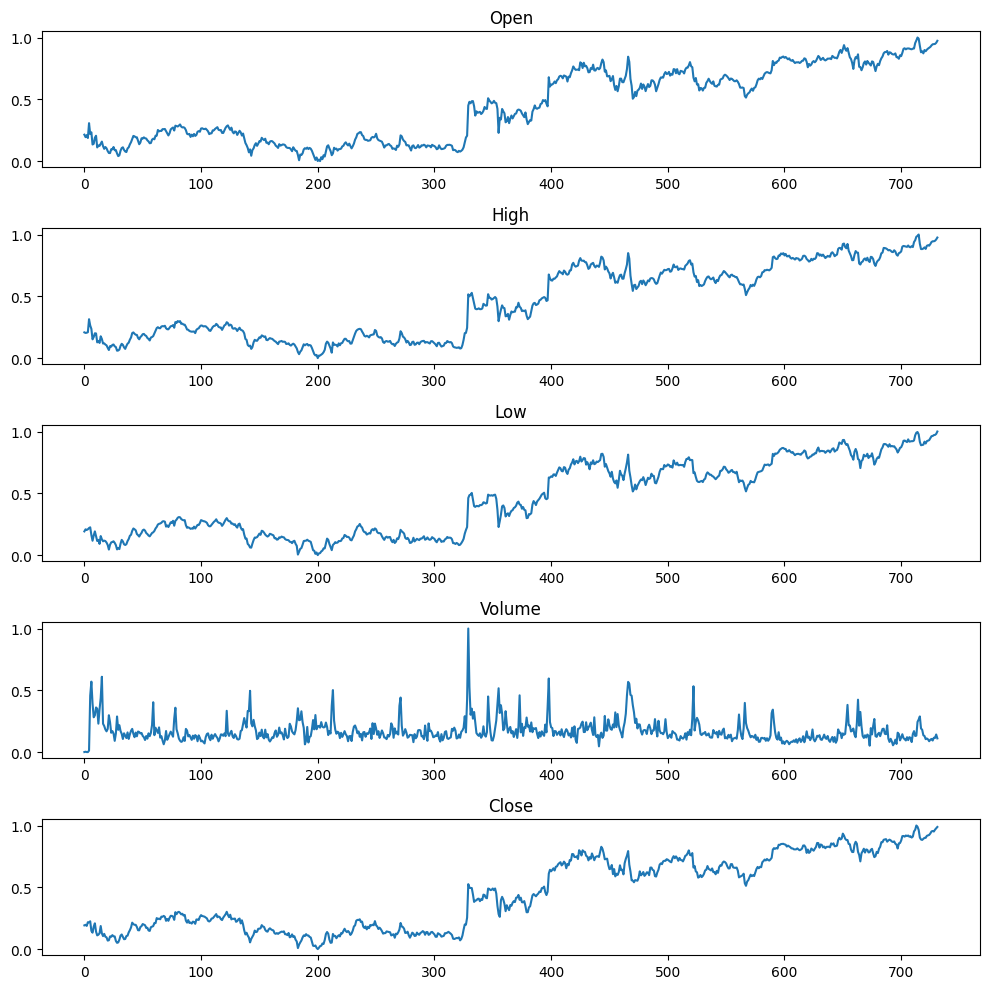

In [11]:
import matplotlib.pyplot as plt

names = ["Open", "High", "Low", "Volume", "Close"]
# Create a grid of subplots
fig, axes = plt.subplots(dim, 1, figsize=(10, 10))

for i in range(dim):
    axes[i].plot(data[:, i])
    axes[i].set_title(names[i])

plt.tight_layout()

plt.show()

In [12]:
data.shape

(732, 5)

In [13]:
ori_x[0]

array([[2.13751054e-01, 2.08179810e-01, 1.91791832e-01, 4.66075110e-04,
        1.92092403e-01],
       [1.93935034e-01, 2.03641926e-01, 2.08664571e-01, 2.98467330e-03,
        1.96551555e-01],
       [2.10516454e-01, 2.05289413e-01, 2.03558748e-01, 2.59926504e-04,
        1.87749731e-01],
       [1.86678765e-01, 2.09480567e-01, 2.08781843e-01, 0.00000000e+00,
        2.17448151e-01],
       [3.06973882e-01, 3.14634137e-01, 2.18993665e-01, 1.24764722e-02,
        2.16981885e-01],
       [2.19142111e-01, 2.63907214e-01, 2.24686396e-01, 4.56323384e-01,
        2.24967474e-01],
       [2.33129931e-01, 2.36419163e-01, 1.62682724e-01, 5.70171193e-01,
        1.47442742e-01]])

In [14]:
# e.q. to temp_ori_x
ori_x[-1]

array([[0.91753068, 0.90955899, 0.93013248, 0.08799857, 0.92390372],
       [0.92391259, 0.92282604, 0.94550876, 0.10049296, 0.93588207],
       [0.93644323, 0.93932734, 0.96226395, 0.10667742, 0.95211558],
       [0.94518557, 0.94522671, 0.96376051, 0.09372591, 0.95564213],
       [0.9462346 , 0.94522671, 0.97100833, 0.11616922, 0.9513578 ],
       [0.94789567, 0.94927335, 0.97250489, 0.11417048, 0.96645463],
       [0.95690035, 0.95988111, 0.9803545 , 0.14250246, 0.97785024]])

no: 732 - 7 = 725 observations \
dim: 5 time series dimensions \
seq_len: 7 time steps \
hidden_dim: 10

In [15]:
m = list()
x = list()
t = list()

for i in range(no):
    # m
    temp_m = 1 * (np.random.uniform(0, 1, [seq_len, dim]) > missing_rate)
    m = m + [temp_m]
    # x
    temp_x = ori_x[i].copy()
    temp_x[np.where(temp_m == 0)] = np.nan
    x = x + [temp_x]
    # t
    temp_t = np.ones([seq_len, dim])
    for j in range(dim):
        for k in range(1, seq_len):
            if temp_m[k, j] == 0:
                temp_t[k, j] = temp_t[k - 1, j] + 1
    t = t + [temp_t]

In [16]:
np.array(x).shape

(725, 7, 5)

In [17]:
temp_x

array([[0.91753068, 0.90955899, 0.93013248, 0.08799857, 0.92390372],
       [       nan,        nan, 0.94550876, 0.10049296,        nan],
       [0.93644323, 0.93932734, 0.96226395, 0.10667742, 0.95211558],
       [       nan, 0.94522671, 0.96376051,        nan,        nan],
       [       nan, 0.94522671, 0.97100833,        nan,        nan],
       [0.94789567, 0.94927335, 0.97250489, 0.11417048, 0.96645463],
       [0.95690035, 0.95988111,        nan,        nan, 0.97785024]])

In [18]:
temp_m

array([[1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 1]])

In [19]:
temp_t

array([[1., 1., 1., 1., 1.],
       [2., 2., 1., 1., 2.],
       [1., 1., 1., 1., 1.],
       [2., 1., 1., 2., 2.],
       [3., 1., 1., 3., 3.],
       [1., 1., 1., 1., 1.],
       [1., 1., 2., 2., 1.]])

In [26]:
t

[array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 2., 1., 1., 1.],
        [1., 3., 2., 2., 1.],
        [2., 1., 1., 3., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 2., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 2.]]),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 2., 1.],
        [1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 2., 1., 1.]]),
 array([[1., 1., 1., 1., 1.],
        [2., 1., 2., 1., 2.],
        [1., 1., 1., 1., 1.],
        [1., 1., 2., 2., 1.],
        [1., 1., 3., 1., 1.],
        [1., 1., 1., 1., 2.],
        [1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 2., 2.],
        [1., 2., 1., 1., 1.],
  

In [20]:
(temp_x[:, 0], temp_m[:, 0], temp_t[:, 0])

(array([0.91753068,        nan, 0.93644323,        nan,        nan,
        0.94789567, 0.95690035]),
 array([1, 0, 1, 0, 0, 1, 1]),
 array([1., 2., 1., 2., 3., 1., 1.]))

In [21]:
np.dstack((temp_x[:, 0], temp_m[:, 0], temp_t[:, 0]))

array([[[0.91753068, 1.        , 1.        ],
        [       nan, 0.        , 2.        ],
        [0.93644323, 1.        , 1.        ],
        [       nan, 0.        , 2.        ],
        [       nan, 0.        , 3.        ],
        [0.94789567, 1.        , 1.        ],
        [0.95690035, 1.        , 1.        ]]])

In [22]:
np.dstack((temp_x, temp_m, temp_t))[:, 0]

array([[0.91753068, 1.        , 1.        ],
       [       nan, 0.        , 2.        ],
       [0.93644323, 1.        , 1.        ],
       [       nan, 0.        , 2.        ],
       [       nan, 0.        , 3.        ],
       [0.94789567, 1.        , 1.        ],
       [0.95690035, 1.        , 1.        ]])

In [23]:
x[-1]

array([[0.91753068, 0.90955899, 0.93013248, 0.08799857, 0.92390372],
       [       nan,        nan, 0.94550876, 0.10049296,        nan],
       [0.93644323, 0.93932734, 0.96226395, 0.10667742, 0.95211558],
       [       nan, 0.94522671, 0.96376051,        nan,        nan],
       [       nan, 0.94522671, 0.97100833,        nan,        nan],
       [0.94789567, 0.94927335, 0.97250489, 0.11417048, 0.96645463],
       [0.95690035, 0.95988111,        nan,        nan, 0.97785024]])

In [80]:
# np.dstack((np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0]))
# np.dstack((np.array(x)[n. de time frames, time steps, features], np.array(m)[:, :, 0], np.array(t)[:, :, 0]))
np.dstack((np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0]))[-1 :, :, :]

array([[[0.91753068, 1.        , 1.        ],
        [       nan, 0.        , 2.        ],
        [0.93644323, 1.        , 1.        ],
        [       nan, 0.        , 2.        ],
        [       nan, 0.        , 3.        ],
        [0.94789567, 1.        , 1.        ],
        [0.95690035, 1.        , 1.        ]]])

In [25]:
np.dstack((np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0])).shape

(725, 7, 3)

In [77]:
np.dstack(np.flip((np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0]), axis=1)).shape

(725, 7, 3)

In [81]:
np.dstack(np.flip((np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0]), axis=1))[:1, :, :]

array([[[0.91753068, 1.        , 1.        ],
        [       nan, 0.        , 2.        ],
        [0.93644323, 1.        , 1.        ],
        [       nan, 0.        , 2.        ],
        [       nan, 0.        , 3.        ],
        [0.94789567, 1.        , 1.        ],
        [0.95690035, 1.        , 1.        ]]])

### batch formation

In [27]:
batch_idx = np.random.permutation(725)[: 128]
np.random.permutation(725)[: 128]

array([457, 323, 136,  77, 144, 520, 150, 700, 441, 699, 526, 404, 535,
        66, 220, 539, 516, 703, 322, 427,   7, 156, 194, 140,  92, 657,
       439, 435, 436,  17, 405, 360, 374, 361, 394, 440, 209, 564, 696,
       197, 586, 295, 273, 367, 446, 425, 562, 599,  97, 363, 261, 162,
       651, 712, 659, 583, 532, 145, 480, 341, 589, 453, 357, 191, 554,
       198, 660, 667, 326, 571,  89, 720, 262, 694, 448, 372, 689, 603,
       416, 281, 501, 193, 508, 392, 294, 246, 182, 292, 670, 430, 401,
       391, 684, 476, 300,  83, 559,  33, 661, 251, 234, 384, 109,  62,
       632, 434, 258,  53, 240, 158, 612, 173, 582, 584, 598, 129, 333,
       707, 592, 406,  61, 527, 613, 482, 309,  55, 351, 319])

In [28]:
f_input = np.zeros([batch_size, seq_len, 3])

In [33]:
b_input = np.zeros([batch_size, seq_len, 3])

for the foward and backward pass, the batch is randomly sampled from the `no_of_observations` **(725)** and the `seq_len - 1` **(6)** 1-shift time steps (_lagged_) are used to predict the next time step, in all 3 dimensions matrices stacked (x, m, t).

In [34]:
f_input[:, 1:, :] = np.dstack(
    (np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0])
)[batch_idx, : (seq_len - 1), :]

In [35]:
b_input[:, 1:, :] = np.dstack(
    np.flip((np.array(x)[:, :, 0], np.array(m)[:, :, 0], np.array(t)[:, :, 0]), axis=1)
)[batch_idx, : (seq_len - 1), :]

In [48]:
# display the first example in the transposed f_input
tf.transpose(f_input, [1, 0, 2])[:, 0, :]

<tf.Tensor: shape=(7, 3), dtype=float64, numpy=
array([[0.        , 0.        , 0.        ],
       [0.64721766, 1.        , 1.        ],
       [0.66662556, 1.        , 1.        ],
       [0.64812103, 1.        , 1.        ],
       [       nan, 0.        , 2.        ],
       [0.62501214, 1.        , 1.        ],
       [       nan, 0.        , 2.        ]])>

In [87]:
b_input.shape

(128, 7, 3)

In [89]:
# display the last example in the transposed b_input
tf.transpose(b_input, [1, 0, 2]).shape

TensorShape([7, 128, 3])

muda para:

(time step, n. bloco de batch, dimensão da série temporal)

## Treinamento